### Train for MICCAI challenge on colab using data on gDrive

In [2]:
# imports
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score, average_precision_score
from torch import optim
from torch.utils.data import DataLoader
import time

from ails_miccai_uwf4dr_challenge.models.metrics import sensitivity_score, specificity_score
from ails_miccai_uwf4dr_challenge.models.trainer import Metric, DefaultMetricsEvaluationStrategy, Trainer, TrainingContext, MetricCalculatedHook, PersistBestModelOnEpochEndHook
from ails_miccai_uwf4dr_challenge.dataset import DatasetBuilder, DatasetOriginationType, ChallengeTaskType, CustomDataset

In [3]:
# select device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

Device: cpu


In [4]:
# setup dataset
#original_data_dir = ails_data_base_path / "raw"
#external_data_dir = ails_data_base_path / "external"
#dataset_builder = DatasetBuilder(dataset='all', task='task1', original_data_dir=original_data_dir, external_data_dir=external_data_dir).get_train_val()
dataset_builder = DatasetBuilder(DatasetOriginationType.ORIGINAL, ChallengeTaskType.TASK1)

In [5]:
import cv2
import numpy as np
from skimage import restoration
import torch
from torchvision.transforms import v2

class GreenChannelEnhancement:
    def __call__(self, img):
        # Convert to numpy array if it's a tensor
        if isinstance(img, torch.Tensor):
            img = img.numpy().transpose((1, 2, 0))

        # Ensure the image is in the correct format
        img = img.astype(np.float32)

        # Separate the channels
        r, g, b = cv2.split(img)

        # Apply Wiener filter to the green channel
        psf = np.ones((5, 5)) / 25
        g_filtered = restoration.wiener(g, psf, balance=0.1)

        # Apply CLAHE to the filtered green channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        g_enhanced = clahe.apply((g_filtered * 255).astype(np.uint8))
        g_enhanced = g_enhanced / 255.0  # Normalize back to range [0, 1]

        # Ensure all channels are the same type
        r = r.astype(np.float32)
        g_enhanced = g_enhanced.astype(np.float32)
        b = b.astype(np.float32)

        # Merge the enhanced green channel back with the original red and blue channels
        enhanced_img = cv2.merge((r, g_enhanced, b))

        # Convert back to tensor
        enhanced_img = torch.from_numpy(enhanced_img.transpose((2, 0, 1)))
        return enhanced_img

In [23]:
import cv2
import numpy as np
import torch
from torchvision import transforms

class CropFundus:
    def __init__(self, target_size=(448, 448)):
        self.target_size = target_size

    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy array in HWC format

        # Ensure the image is in the correct format
        img = img.astype(np.uint8)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply threshold to get binary image
        _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the largest contour
            largest_contour = max(contours, key=cv2.contourArea)

            # Get bounding box for the largest contour
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Crop the image using the bounding box
            cropped_img = img[y:y+h, x:x+w]
        else:
            cropped_img = img  # If no contours found, use the original image

        # Resize the cropped image to the target size
        resized_img = cv2.resize(cropped_img, self.target_size)

        # Debugging prints
        print("Original image shape:", img.shape)
        print("Cropped image shape:", cropped_img.shape)
        print("Resized image shape:", resized_img.shape)
        print("Max pixel value before normalization:", np.max(resized_img))
        print("Min pixel value before normalization:", np.min(resized_img))

        # Ensure the image is in the correct format and normalize pixel values
        resized_img = resized_img.astype(np.float32) / 255.0  # Normalize to [0, 1]

        # Convert back to tensor
        resized_img = torch.from_numpy(resized_img).permute(2, 0, 1).float()  # Convert back to tensor

        # Debugging prints
        print("Max pixel value after normalization:", torch.max(resized_img).item())
        print("Min pixel value after normalization:", torch.min(resized_img).item())

        return resized_img

In [24]:
from torchvision.transforms import v2
import torch

just_to_image = v2.Compose([
    v2.ToPILImage(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

# use this augmentation pipeline in the case of:
# 1. training
# 2. both datasets are included (therefore: resizing or cropping)
augment_for_task_1_training = v2.Compose([
    v2.ToPILImage(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    GreenChannelEnhancement(),
    #v2.ColorJitter(brightness=0.5, contrast=0.4, saturation=0.3, hue=0.3),
    v2.RandomHorizontalFlip(),

    #v2.RandomVerticalFlip(),
    #v2.RandomRotation(degrees=15, expand=True),
    #v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    v2.Resize(size=(224, 224), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augment_for_task_1_validation = v2.Compose([
    v2.ToPILImage(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    GreenChannelEnhancement(),
    #v2.ColorJitter(brightness=0.5, contrast=0.4, saturation=0.3, hue=0.3),
    #v2.RandomHorizontalFlip(),
    #v2.RandomVerticalFlip(),
    #v2.RandomRotation(degrees=15, expand=True),
    #v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    v2.Resize(size=(224, 224), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Dataset length:  347
Original image shape: (800, 1016, 3)
Cropped image shape: (800, 1016, 3)
Resized image shape: (448, 448, 3)
Max pixel value before normalization: 1
Min pixel value before normalization: 0
Max pixel value after normalization: 0.003921568859368563
Min pixel value after normalization: 0.0
Original image shape: (800, 1016, 3)
Cropped image shape: (800, 1016, 3)
Resized image shape: (448, 448, 3)
Max pixel value before normalization: 1
Min pixel value before normalization: 0
Max pixel value after normalization: 0.003921568859368563
Min pixel value after normalization: 0.0
Original image shape: (800, 1016, 3)
Cropped image shape: (800, 1016, 3)
Resized image shape: (448, 448, 3)
Max pixel value before normalization: 1
Min pixel value before normalization: 0
Max pixel value after normalization: 0.003921568859368563
Min pixel value after normalization: 0.0
Original Images:


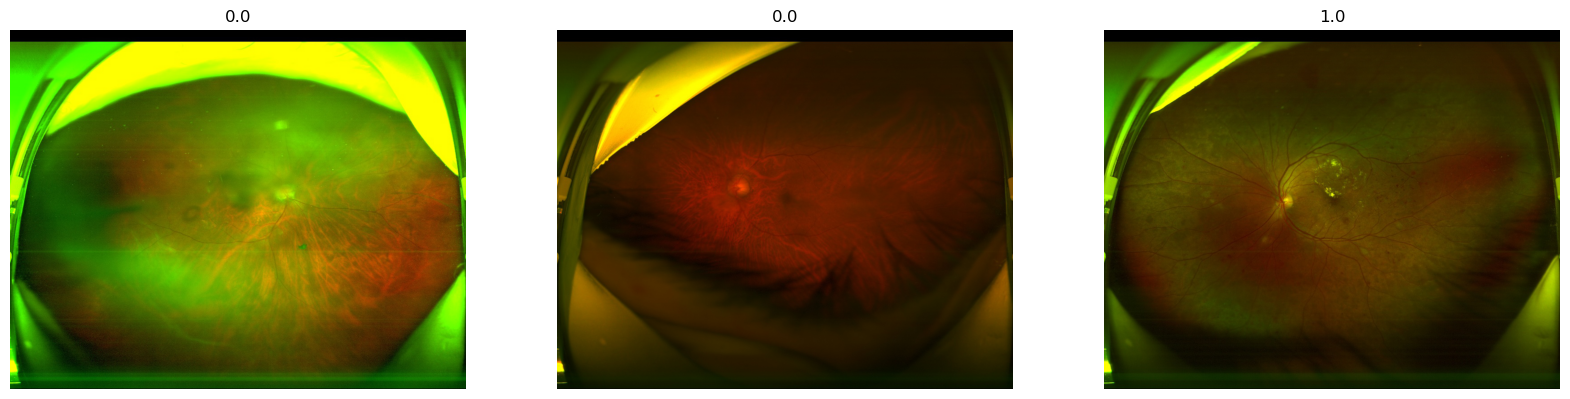

Enhanced Images:


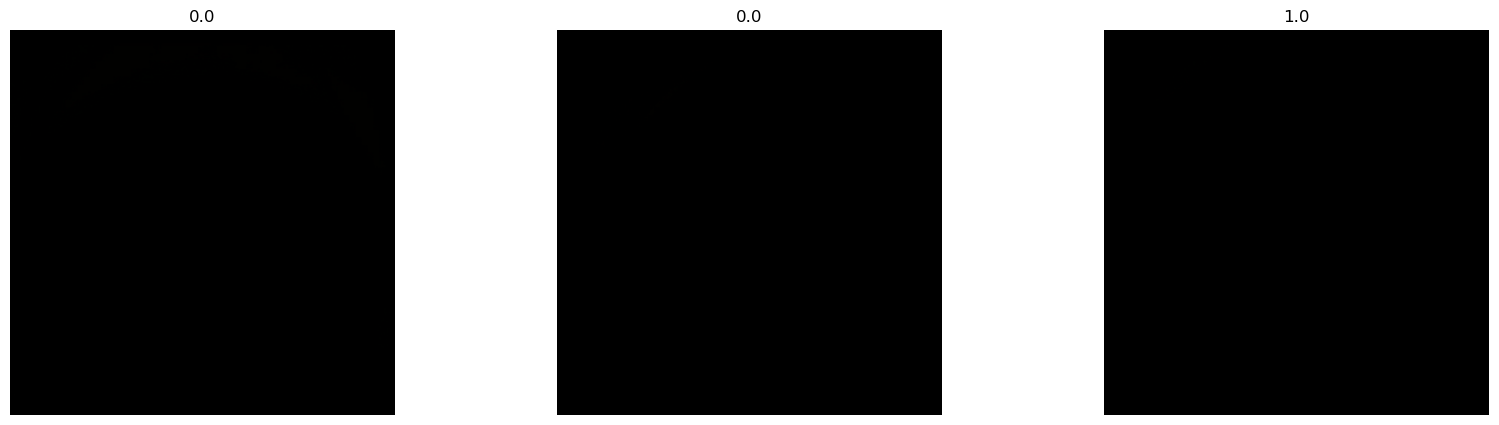

In [25]:

import matplotlib.pyplot as plt

train_data, val_data = dataset_builder.get_train_val()
train_dataset = CustomDataset(train_data, just_to_image)
img_data_loader = DataLoader(train_dataset)

# Function to display images
def show_images(images, titles=None):
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(20, 5))
    if n == 1:
        axs = [axs]
    for i, img in enumerate(images):
        img = img.permute(1, 2, 0).numpy()  # Convert to HxWxC for visualization
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img)
        axs[i].axis('off')
        if titles:
            axs[i].set_title(titles[i])
    plt.show()

# Display first 5 images from train_loader before and after GreenChannelEnhancement
images_before = []
images_after = []
labels = []

# Get 5 images from the loader
for i, (img, label) in enumerate(img_data_loader):
    if i == 3:
        break
    images_before.append(img[0].clone())  # Store a clone of the original image
    #transformed_img = GreenChannelEnhancement()(img[0])  # Apply the enhancement
    transformed_img = CropFundus()(img[0].clone())
    images_after.append(transformed_img)  # Store the transformed image
    labels.append(label[0].item())

# Show original images
print("Original Images:")
show_images(images_before, titles=labels)

# Show enhanced images
print("Enhanced Images:")
show_images(images_after, titles=labels)
